# Earthquake Multiclass Classification 

This notebook is an improved version of the solution submitted for the hackathon event of the **G2NET Training School - Machine Learning and Signal processing for Time Series Analysis** held at the University of Malta on March 2020.

The goal of the event is to build a model capable of **classify different types of earthquakes** from all over the world together with noise (non-earthquake ambient noise) given the available data.

The datasets used in this notebook can be found in the repository of G2NET Training School. There are three pickle files that are required to run this notebook:
- **df_train.pkl.gzip and df_test.pkl.gzip**: Labelled datasets with earthquake meta data and 3 traces (E-N-Z).
- **df_submission.pkl.gzip**: Unlabelled data to be submitted at the end of the challange.



## 1. Imports

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]=""
import keras
from keras.utils import to_categorical
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, MaxPooling1D, Flatten, Reshape, BatchNormalization, Activation, GlobalAveragePooling1D
from keras.layers.merge import concatenate, Add
from keras.models import Model, load_model, Sequential
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
import tensorflow as tf

from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

flag1


## 2. Data Files

We define two different Pandas Data Frames for the training and validation data provided

In [2]:
df_train = pd.read_pickle('./data/df_train.pkl.gzip', compression='gzip')
df_test = pd.read_pickle('./data/df_test.pkl.gzip', compression='gzip')

## 3. Exploratory Data Analysis

We check our data and ensure the different features are in the correct format for processing. 
The data set contains **12308 training samples and 3078 testing samples** that we will use for validation later on, each set with **19 different features** including the label of the event.

In [3]:
print(f'Train Data Shape: \nRows: {df_train.shape[0]} - Columns: {df_train.shape[1]}')
print(f'Test Data Shape: \nRows: {df_test.shape[0]} - Columns: {df_test.shape[1]}')
df_train.head(2)

Train Data Shape: 
Rows: 12308 - Columns: 19
Test Data Shape: 
Rows: 3078 - Columns: 19


,label,target,trace_id,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_travel_sec,s_arrival_sample,source_origin_time,source_latitude,source_longitude,source_depth_km,snr_db_E,snr_db_N,snr_db_Z,E,N,Z
1,Near_Small,1,trace_1,33.598182,-116.596005,1374.8,500.0,7.39588,1833.0,2017-10-12 02:55:02.969,35.561667,-116.5697,13.92,39.799999,41.599998,39.500000,"[0.0, 3.884492e-05, 0.00037855064, 0.002025907...","[-0.0, -0.00013965365, 0.00040082424, -0.00251...","[0.0, 0.00020642515, -0.00026392427, 0.0005670..."
2,Far_Medium,5,trace_2,33.655160,-115.990060,538.0,800.0,8.64000,2055.2,2012-05-29 21:39:41.030,69.509000,-116.3350,5.56,22.900000,28.299999,22.299999,"[-0.0, 0.007055464, 0.02053014, -0.08816139, -...","[0.0, 0.0045861118, -0.013594023, -0.06492513,...","[0.0, 0.010553602, 0.04499443, 0.07075505, -0...."


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12308 entries, 1 to 15399
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   label                 12308 non-null  object        
 1   target                12308 non-null  int64         
 2   trace_id              12308 non-null  object        
 3   receiver_latitude     12308 non-null  float64       
 4   receiver_longitude    12308 non-null  float64       
 5   receiver_elevation_m  12308 non-null  float64       
 6   p_arrival_sample      12308 non-null  float64       
 7   p_travel_sec          12308 non-null  float64       
 8   s_arrival_sample      12308 non-null  float64       
 9   source_origin_time    12308 non-null  datetime64[ns]
 10  source_latitude       12308 non-null  float64       
 11  source_longitude      12308 non-null  float64       
 12  source_depth_km       12308 non-null  float64       
 13  snr_db_E        

This data set has been curated and the training and the testing data don't have any NaN values nor outliers, so we don't have to worry about further data cleansing.

### 3.1 Classification Labels

There are 7 possible classification labels per sample. Each label provides information about the intensity and the proximity of the event as a combination **Proximity_Intensity**, and separates real events from **Noise (non-earthquake ambient noise)**.

Samples are almost **equally balanced** for all 7 classes.

In [5]:
labels = df_train.label.value_counts()
print(labels)

Far_Medium     1760
Far_Large      1760
Far_Small      1759
Near_Medium    1759
Noise          1757
Near_Small     1757
Near_Large     1756
Name: label, dtype: int64


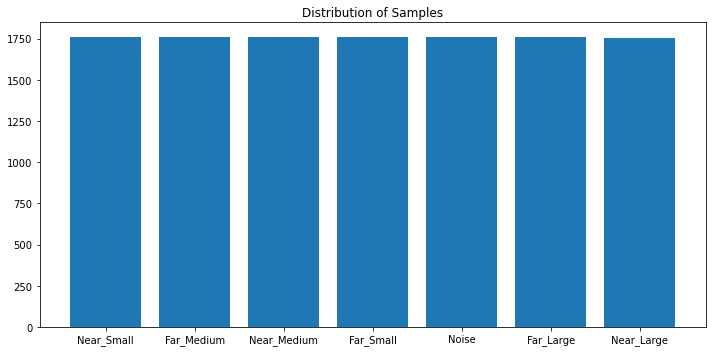

In [6]:
fig,ax = plt.subplots( figsize = (10,5) )
ax.bar(df_train.label.unique(), list(labels) )
ax.set_title('Distribution of Samples')
plt.tight_layout()
plt.show()

### 3.2 Features

There are 13 numerical columns in the DF, 1 of which correspond to the target label of the events, 2 string type columns and 3 array-like features.

- **label** : (str) Text label describing the event.

- **target**: (int) Categorical label describing the event.

- **trace_id**: (str) Id to identify the event in the database.

- **receiver_latitude**: (float) Latitude location of the receiver.

- **receiver_longitude**: (float) Longitudinal location of the receiver.

- **receiver_elevation_m**: (float) Elevalation in metres from see level for the receiver.

- **p_arrival_sample**: (float) Predicted p-wave arrival. Not applicable to Noise.

- **p_travel_sec**: (float) Time taken by the p-wave to travel from the source origin to the receiver location. Not applicable to Noise.

- **s_arrival_sample**: (float) Predicted s-wave arrival. Not applicable to Noise.

- **source_origin_time**: (DateTime) Date for the event source.

- **source_latitude**: (float) Event source latitude.

- **source_longitude**: (float) Event source longitude.

- **source_depth_km**: (float) Event source depth.

- **snr_db_E**: (float) Signal to noise ratio for the E-component of the [seismogram](https://en.wikipedia.org/wiki/Seismogram") trace.

- **snr_db_N**: (float) Signal to noise ratio for the N-component of the seismogram trace.

- **snr_db_Z**:(float)  Signal to noise ratio for the Z-component of the seismogram trace.

- **E**: (array) E-component of the seismogram trace.

- **N**: (array) N-component of the seismogram trace.

- **Z**: (array) Z-component of the seismogram trace.


### 3.2 Numerical Features

To understand the dataset better, let's plot the distribution (KDE) of the different numerical variables. This might give us some clues about what are the most important and useful variables for our model to be able to separate and classify each of the corresponding classes of earthquakes.


In [7]:
df_numeric = df_train.select_dtypes(include = ['float64', 'int64'])
df_numeric.head()

,target,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_travel_sec,s_arrival_sample,source_latitude,source_longitude,source_depth_km,snr_db_E,snr_db_N,snr_db_Z
1,1,33.598182,-116.596005,1374.8,500.0,7.39588,1833.0,35.561667,-116.5697,13.92,39.799999,41.599998,39.500000
2,5,33.655160,-115.990060,538.0,800.0,8.64000,2055.2,69.509000,-116.3350,5.56,22.900000,28.299999,22.299999
4,2,19.333395,-155.385650,836.0,900.0,7.77000,1401.0,33.075200,73.6821,9.41,12.600000,22.000000,18.299999
5,4,35.935700,-117.601700,1042.6,800.0,2.68000,1416.0,38.612300,-122.6970,118.79,30.600000,29.100000,33.000000
6,0,64.564600,-165.373200,338.0,697.2,1.41000,674.0,60.036800,-155.2055,2.17,47.099998,18.100000,49.400002


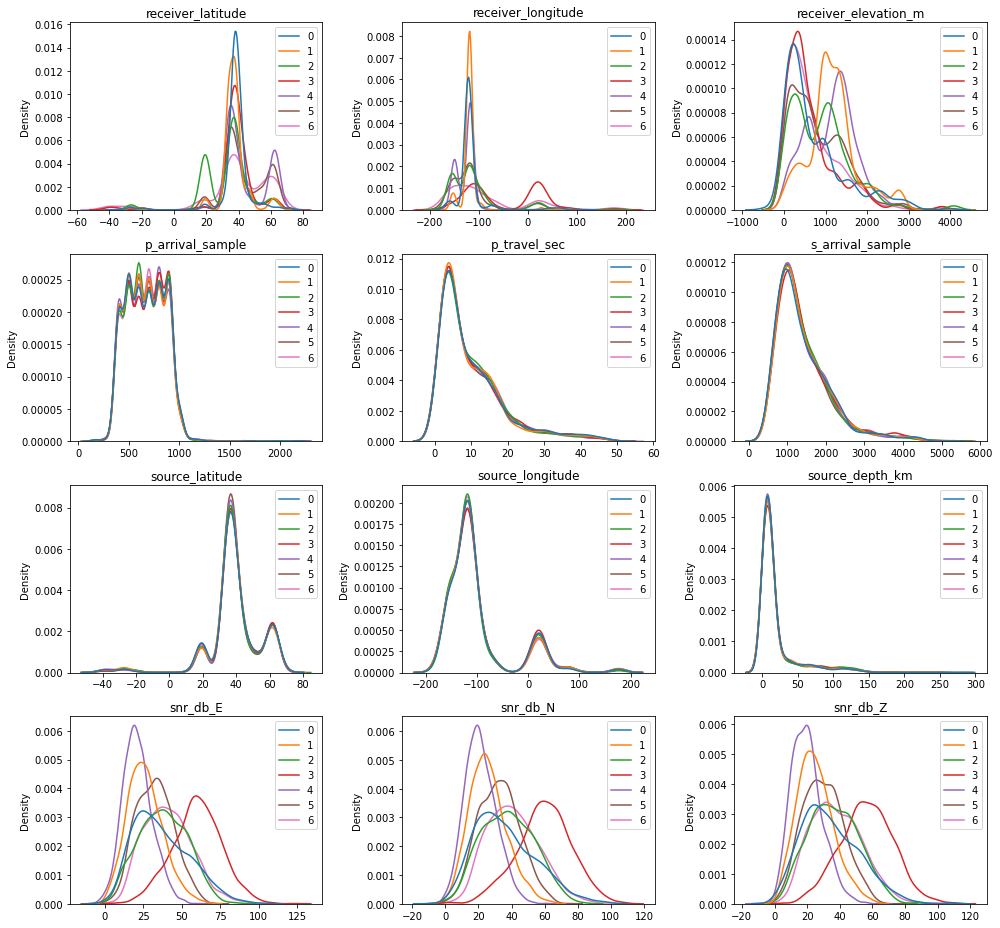

In [8]:
fig,ax = plt.subplots(4,3,figsize=(14,13))
k = 0
for j, col in enumerate(df_numeric.columns[1:]):
    if j!=0 and j%3==0:
        k+=1
    data = [target[1].to_numpy() for target in df_numeric.groupby('target')[col]]
    sns.kdeplot(data = data, ax= ax[ k , j%3])
    ax[ k , j%3].set_title(col)
fig.tight_layout()

### 3.3 Seismogram Traces

Finally, we visualize the E, N, Z seismogram traces for randomly picked samples of each class of earthquake. This traces can be understand together as a multivariable time series, each one being 6000 time steps of length.

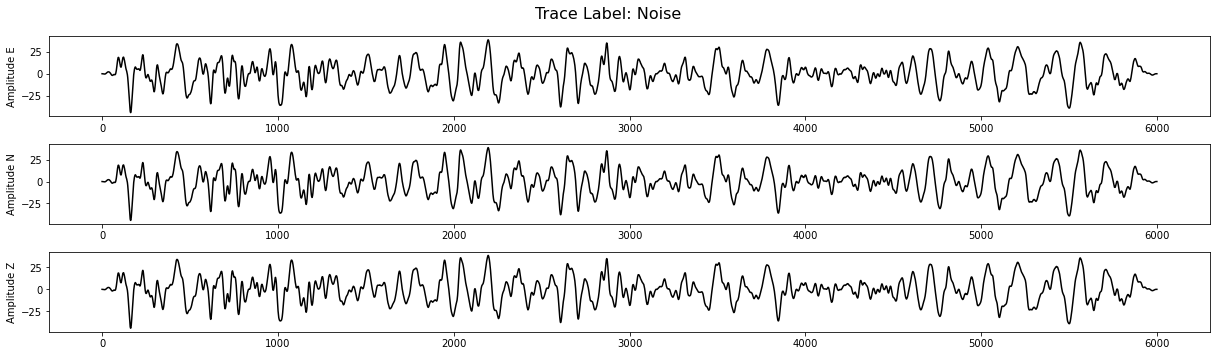

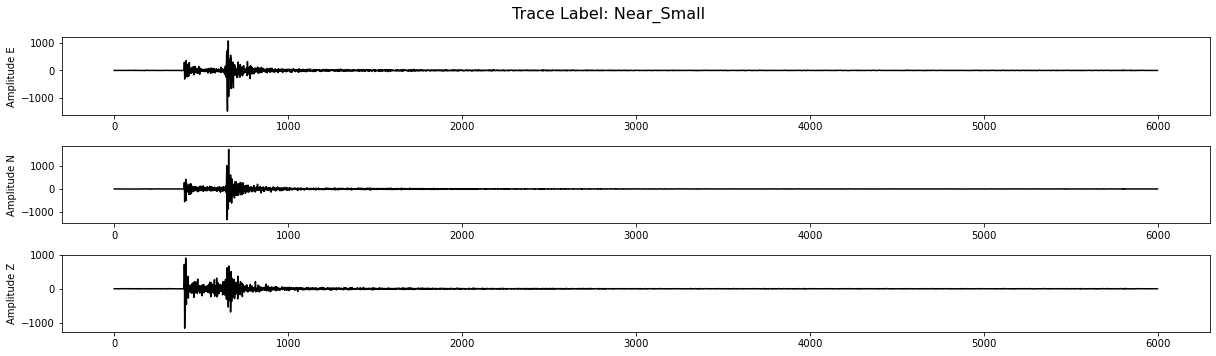

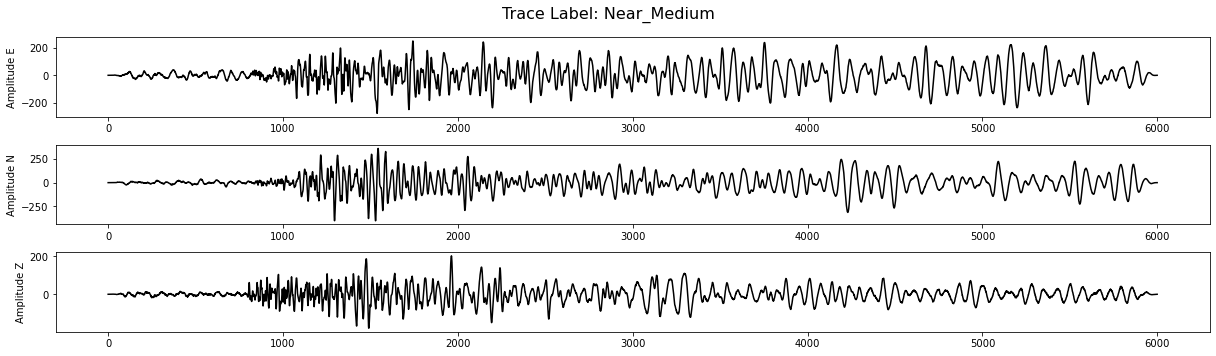

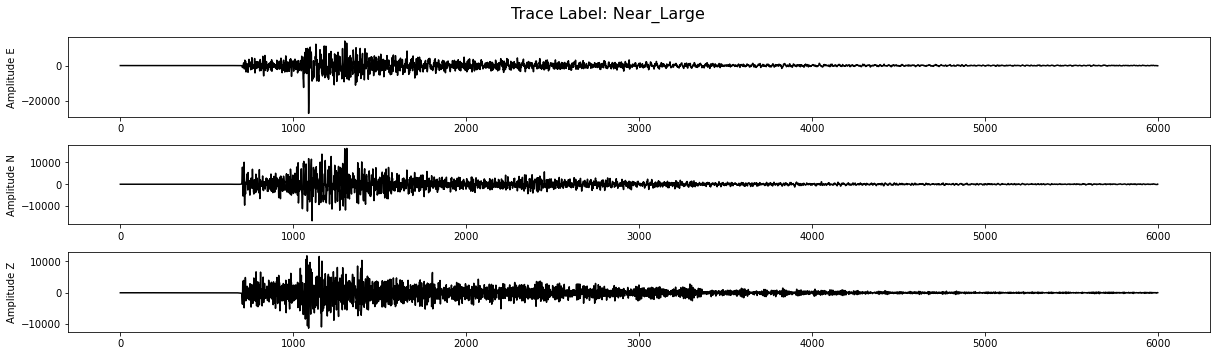

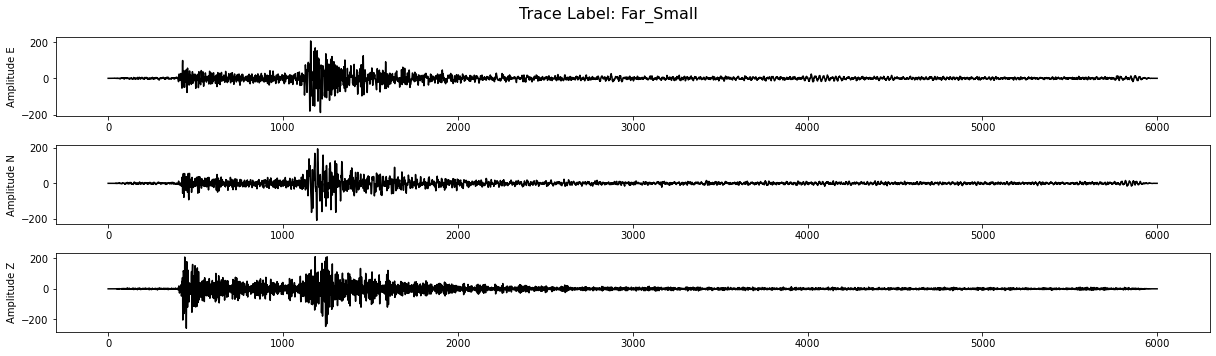

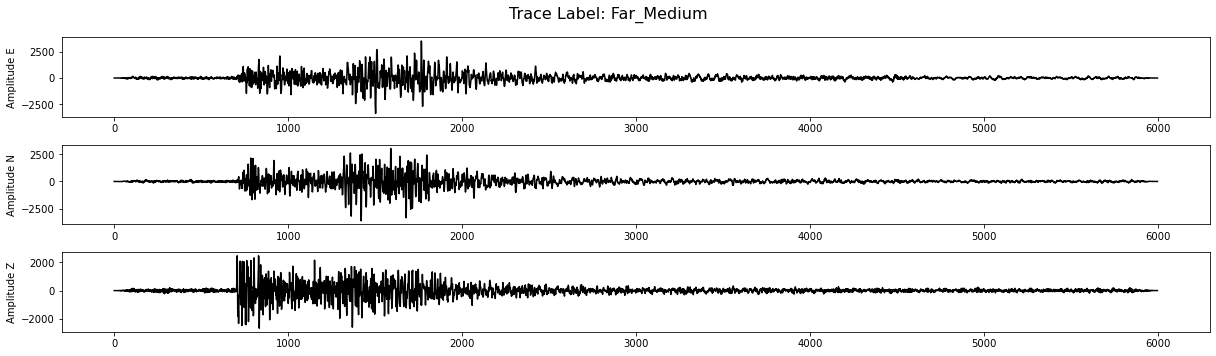

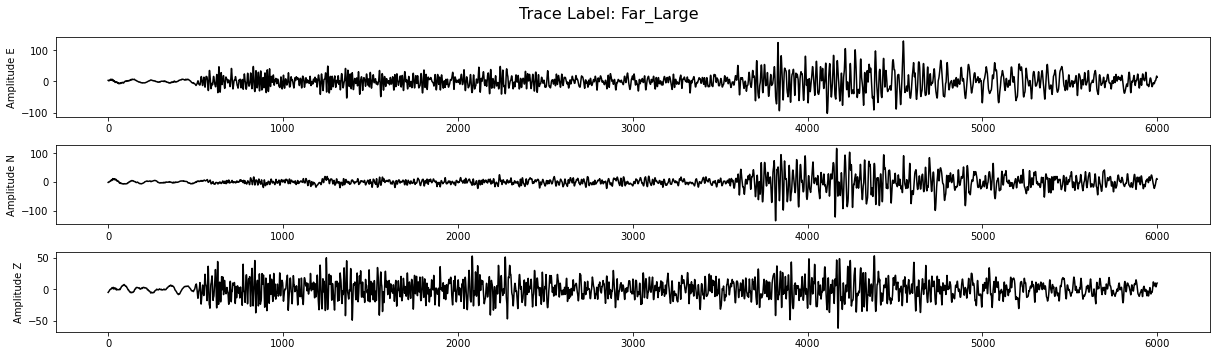

In [9]:
target_list = sorted(df_train['target'].unique())
traces = ['label','E', 'N', 'Z']

for target in target_list:
    fig,ax = plt.subplots(3,1, figsize=(17,5))
    df_trace = df_train[ df_train.target == target ][traces]
    
    fig.suptitle(f'Trace Label: {df_trace.iloc[0,0]}', fontsize=16)
    ax[0].plot(df_trace.iloc[0,1], color='k')
    ax[0].set_ylabel('Amplitude E')
    
    ax[1].plot(df_trace.iloc[0,2], color = 'k')
    ax[1].set_ylabel('Amplitude N')
    
    ax[2].plot(df_trace.iloc[0,3], color = 'k')
    ax[2].set_ylabel('Amplitude Z')
    
    fig.tight_layout()


## 4. Data Preprocessing and Feature Engeniering 

One of the key steps in creating a succesful classification model is to understand the data and process it in a way that is understandable by our model. In particular, appropiate **Standarization or Normalization** of the input variables is a critical step in neural network models, making the learning more stable, as the paramenters will have the same scale for a fair comparison between them.

For this particular case we will standarize our input variables, both the numerical ones as well as the seismogram traces. This standarization is also sometimes refered as Z-Score Standarization, and consists on removing the mean and scaling the variables to unit variance. 

If the mean $\mu$, and standard deviation $\sigma$, of the population are known, the standarized variables can be computed by,

$$ X' = \frac{ X - \mu }{\sigma}$$

where $X'$ are the transformed values and $X$ are the original values.


In [10]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

To standarized the seismogram traces we will use sklearn scaler function *StandardScaler()*. The scaler object is applied to the E, N and Z traces for both training and testing datasets. We then stack the three standarized traces to create a multivariable time series which will be one of the inputs of our model.

In [11]:
scaler = StandardScaler()
for idx,row in df_train.iterrows():
    df_train.at[idx, 'E'] = scaler.fit_transform(df_train.iloc[idx, df_train.columns.get_loc('E')].reshape(-1, 1))
    df_train.at[idx, 'N'] = scaler.fit_transform(df_train.iloc[idx, df_train.columns.get_loc('N')].reshape(-1, 1))
    df_train.at[idx, 'Z'] = scaler.fit_transform(df_train.iloc[idx, df_train.columns.get_loc('Z')].reshape(-1, 1))
    
df_sequential = df_train[["E" , "N", "Z"]].to_numpy()
X1_train = np.array([ np.stack(item).T for item in df_sequential ])[:,0]
print(X1_train.shape)

(12308, 6000, 3)


For the numerical variables, we standarize the features using the Scipy function *zscore()* and reshape the array to have the appropiate dimensions for our model. We also create a new array *y_train* containing all the correct target labels.

In [12]:
df_numeric = df_train[[ 'receiver_latitude', 'receiver_longitude', 'receiver_elevation_m', 
                          'snr_db_E', 'snr_db_N', 'snr_db_Z', 
                        ]]
#df_numeric = df_train.select_dtypes(include = ['float64', 'int64']).drop('target', axis=1)
X2_train = stats.zscore( df_numeric ).reshape(df_numeric.shape[0], 1, df_numeric.shape[1])

y_train = df_train[ ["target"]]
y_train = to_categorical(y_train).reshape(df_numeric.shape[0],1,7)
print(X2_train.shape)

(12308, 1, 6)


We repeat the same preprocessing steps for the validation set and also create a function *preprocessing()*, to standarize more samples if necessary.

In [13]:
for idx,row in df_test.iterrows():
    df_test.at[idx, 'E'] = scaler.fit_transform(df_test.iloc[idx, df_test.columns.get_loc('E')].reshape(-1, 1))
    df_test.at[idx, 'N'] = scaler.fit_transform(df_test.iloc[idx, df_test.columns.get_loc('N')].reshape(-1, 1))
    df_test.at[idx, 'Z'] = scaler.fit_transform(df_test.iloc[idx, df_test.columns.get_loc('Z')].reshape(-1, 1))

df_sequential_test = df_test[["E" , "N", "Z"]].to_numpy()
X1_test = np.array([ np.stack(item).T for item in df_sequential_test ])[:,0]

df_numeric_test = df_test[[ 'receiver_latitude', 'receiver_longitude', 'receiver_elevation_m', 
                          'snr_db_E', 'snr_db_N', 'snr_db_Z' ]]

#df_numeric_test = df_test.select_dtypes(include = ['float64', 'int64']).drop('target', axis=1)
X2_test = stats.zscore( df_numeric_test ).reshape(df_numeric_test.shape[0], 1, df_numeric_test.shape[1])
y_test = df_test[ ["target"]]
y_test = to_categorical(y_test).reshape(df_numeric_test.shape[0],1,7)

In [14]:
def preprocessing(df):
    ''' Function that takes a Pandas DF containing seismic data and standarize the different variables.
        It returns 3 arrays X1, X2 and y, corresponding to the 2 input arrays for the model and the target labels.'''
    scaler = StandardScaler()
    for idx,row in df.iterrows():
        df.at[idx, 'E'] = scaler.fit_transform(df.iloc[idx, df.columns.get_loc('N')].reshape(-1, 1))
        df.at[idx, 'N'] = scaler.fit_transform(df.iloc[idx, df.columns.get_loc('N')].reshape(-1, 1))
        df.at[idx, 'Z'] = scaler.fit_transform(df.iloc[idx, df.columns.get_loc('N')].reshape(-1, 1))

    df_sequential = df[["E" , "N", "Z"]].to_numpy()
    X1 = np.array([ np.stack(item).T for item in df_sequential ])[:,0]

    if 'target' in df.columns:
        #df_numeric = df.select_dtypes(include = ['float64', 'int64']).drop('target', axis=1)
        df_numeric = df[[ 'receiver_latitude', 'receiver_longitude', 'receiver_elevation_m', 
                          'snr_db_E', 'snr_db_N', 'snr_db_Z' ]]
        X2 = stats.zscore( df_numeric ).reshape(df_numeric.shape[0], 1, df_numeric.shape[1])
        y = df[ ["target"]]
        y = to_categorical(y).reshape(df_numeric.shape[0],1,7)
        return X1, X2, y
    else:
        #df_numeric = df.select_dtypes(include = ['float64', 'int64'])
        df_numeric = df[[ 'receiver_latitude', 'receiver_longitude', 'receiver_elevation_m', 
                          'snr_db_E', 'snr_db_N', 'snr_db_Z' ]]
        X2 = stats.zscore( df_numeric ).reshape(df_numeric.shape[0], 1, df_numeric.shape[1])
        return X1, X2, None

## 5. Model Selection

To take advantage of all the data provided in our training set, we will create a Deep Learning Model consisting on two separate branches: 

-  The first of these branches - *model_branch1()* - will take care of the earthquake traces, and therefore its input will be given in the form of a a multidimensional Time Series (E,N,Z traces). To extract the relevant features of this TS, we will use a **one dimensional Convolutional Neural Network (1d-CNN)**, made of 3 blocks, each one consisting of a stack of a 1D Convolution Layer, Batch Normalization Layer, Dropout layer and a 1D MaxPolling layer. At the end of the last block, the output is then flatten and fed to a final Dense Layer.


- The second branch - *model_branch2()* - will take care of the numerical features. It is a **Fully Connected Neural Network (FCNN)** with 3 hidden layers.

The final model - *merged_model()* - is then the concatenation of the 2 branches, which is then fed into 2 fully connected layers before the final output layer. 

In [15]:
input_shape1 = ( X1_train.shape[1], X1_train.shape[2])
input_shape2 = ( X2_train.shape[1], X2_train.shape[2])


def model_branch1(input_shape):
    #input1 = Input( shape=(6000, 3) )
    input1 = Input( shape= input_shape )
    
    
    convolved = Conv1D( 64, 32, padding='same', activation="relu")(input1)
    convolved = BatchNormalization()(convolved)
    drop = Dropout(0.2)(convolved)
    processed = MaxPooling1D(pool_size=5)(drop)
    
    convolved = Conv1D( 32, 16, padding='same', activation="relu")(processed)
    convolved = BatchNormalization()(convolved)
    drop = Dropout(0.2)(convolved)
    processed = MaxPooling1D(pool_size=5)(drop)
    
    convolved = Conv1D( 16, 3, padding='same', activation="relu")(processed)
    convolved = BatchNormalization()(convolved)
    drop = Dropout(0.2)(convolved)
    processed = MaxPooling1D(pool_size=5)(drop)

    flat = Flatten()(processed)
    dense = Dense(64, activation='relu')(flat)
    dense = Dense(7, activation='relu')(dense)
    
    reshape = Reshape((1,-1))(dense)
    model1 = Model(inputs = input1, outputs=reshape) 
    return model1
    
def model_branch2(input_shape):
   # input2 = Input(shape= (1,12))
    input2 = Input(shape= input_shape)
    
   # x = Dense(128,activation='relu')(input2)
    x = Dense(64,activation='relu')(input2)
    x = Dense(32,activation='relu')(x)
    model2 = Model(inputs = input2, outputs=x)
    return model2
    

def merged_model():
    model_1 = model_branch1(input_shape1)
    model_2 = model_branch2(input_shape2)
    merged = concatenate( [model_1.output, model_2.output] )

    compressed = Dense(128, activation="relu")(merged)
    compressed = Dense(32, activation="relu")(compressed)
    output = Dense(7, activation='softmax')(compressed) 
    
    model = Model(inputs=[model_1.input, model_2.input], outputs=output)                   
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'] )
    
    return model
  

flag6


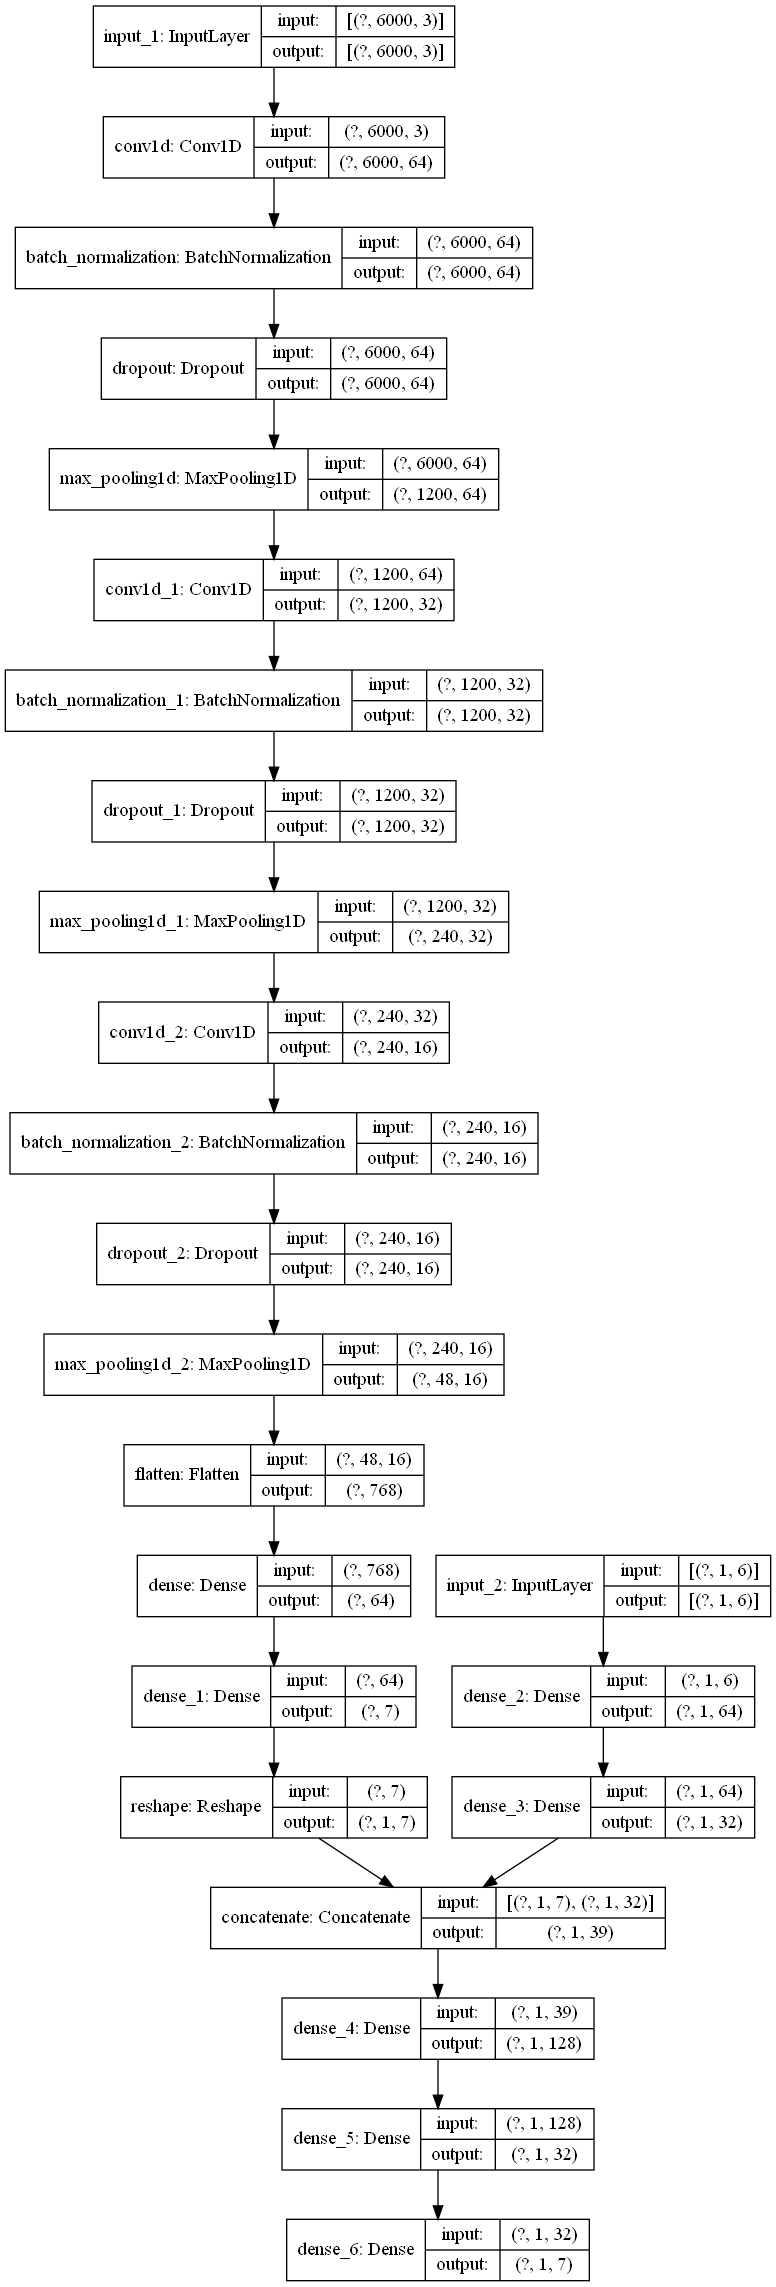

In [16]:
model = merged_model()
plot_model(model,show_shapes=True)

## 6. Model Training and Validation

To train our model, we will use Adam optimizer and a Categorical Crossentropy Loss Function. The hyperparameters of the model such as the number of nodes in the dense layers, the kernel size and number of filters in the convolutions, etc., were chosen by trial and error.


The model presented here was already trained 300 epochs, and reached an accuracy in the validation set of 81%. The retraining of the model is just for visualization purposes.

In [17]:
model = load_model("./models/checkpoint_model_081.h5")

In [19]:
callback1 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
callback2 = ModelCheckpoint(filepath='checkpoint_model.h5', monitor='val_loss', save_best_only=True,verbose=1)
callbacks = [callback1,callback2]

history = model.fit( 
                    [ X1_train, X2_train ],  y_train, 
                    epochs=15,
                    batch_size = 32, 
                    validation_data=([ X1_test, X2_test ],  y_test),
                    callbacks=callbacks
                   )

Epoch 1/15
384/385 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8787
Epoch 00001: val_loss improved from inf to 0.52555, saving model to checkpoint_model.h5
385/385 [==============================] - 10s 25ms/step - loss: 0.2994 - accuracy: 0.8788 - val_loss: 0.5256 - val_accuracy: 0.8119
Epoch 2/15
385/385 [==============================] - ETA: 0s - loss: 0.2880 - accuracy: 0.8824
Epoch 00002: val_loss improved from 0.52555 to 0.51508, saving model to checkpoint_model.h5
385/385 [==============================] - 9s 25ms/step - loss: 0.2880 - accuracy: 0.8824 - val_loss: 0.5151 - val_accuracy: 0.8151
Epoch 3/15
384/385 [============================>.] - ETA: 0s - loss: 0.2856 - accuracy: 0.8830
Epoch 00003: val_loss did not improve from 0.51508
385/385 [==============================] - 9s 25ms/step - loss: 0.2858 - accuracy: 0.8830 - val_loss: 0.5316 - val_accuracy: 0.8070
Epoch 4/15
383/385 [============================>.] - ETA: 0s - loss: 0.2727 - accur

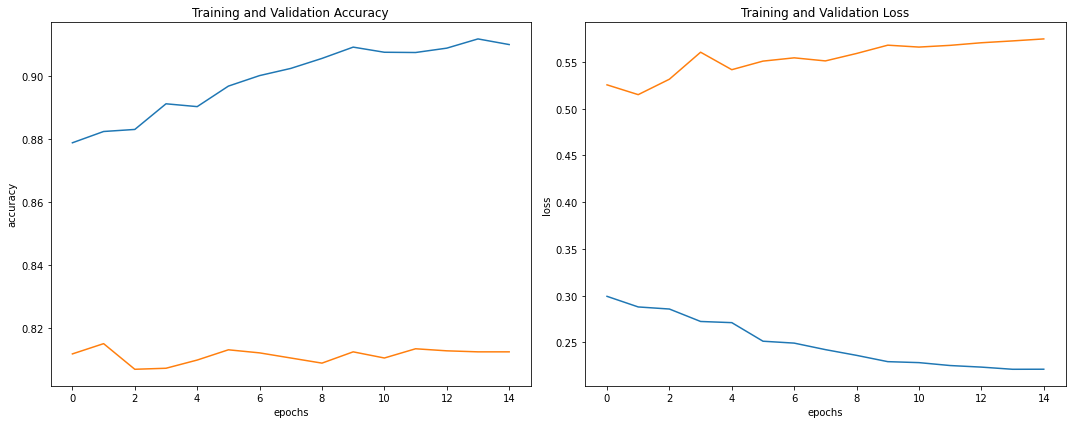

In [20]:
fig, ax = plt.subplots( 1, 2, figsize=(15,6) )

ax[0].plot( history.history['accuracy'])
ax[0].plot( history.history['val_accuracy'])
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracy')

ax[1].plot( history.history['loss'])
ax[1].plot( history.history['val_loss'])
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('loss')

plt.tight_layout()
plt.show()

## 7. Validation Results

In [18]:
y_pred = model.predict([X1_test, X2_test])
y_pred_new = []
for y in y_pred:
    y_pred_new.append( np.argmax(y) )
    
y_test_new = []
for y in y_test:
    y_test_new.append( np.argmax(y) )

In [27]:
print(classification_report(y_test_new, y_pred_new))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       439
           1       0.90      0.76      0.83       439
           2       0.74      0.78      0.76       440
           3       0.89      0.86      0.88       440
           4       0.74      0.85      0.79       440
           5       0.67      0.62      0.65       440
           6       0.80      0.85      0.82       440

    accuracy                           0.82      3078
   macro avg       0.82      0.82      0.82      3078
weighted avg       0.82      0.82      0.82      3078



In [53]:
def plot_confustion_matrix(y_test, y_predicted, df, prob=False):
    if prob:
        cms = confusion_matrix(y_test.argmax(1), y_predicted.argmax(1))
    else:
        cms = confusion_matrix(y_test, y_predicted)
    test_score = np.trace(cms) / np.sum(cms)
    fig = plt.figure(figsize=(18, 14))
    ax = fig.add_subplot(111)
    im = ax.imshow(np.transpose(cms), interpolation="nearest", cmap="RdPu")
    rows = cms.shape[0]
    cols = cms.shape[1]
    for x in range(0, rows):
        for y in range(0, cols):
            value = int(cms[x, y])
            ax.text(x, y, value, color="black", ha="center", va="center")
    plt.title("Validation Data vs Prediction : Accuracy: {}".format(test_score))
    plt.colorbar(im)
    
    df_labels = df[['target','label']].drop_duplicates().sort_values(by='target')
    classes_values = [tt for tt in df_labels['target']]
    classes_labels = [tt for tt in df_labels['label']]

    plt.xticks(classes_values, classes_labels)
    plt.yticks(classes_values, classes_labels)
    plt.xlabel("Real data")
    plt.ylabel("Predicted data")
    plt.show()


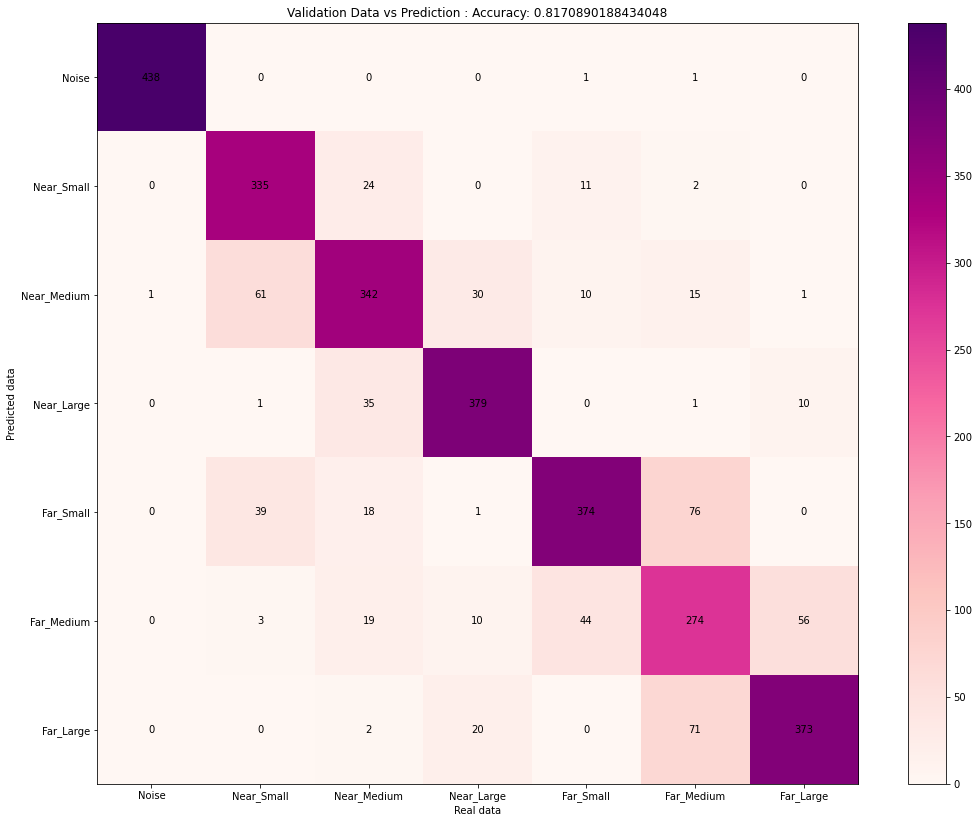

In [54]:
plot_confustion_matrix(y_test_new, y_pred_new, df_train, prob=False)

## 8. Submission 

In [21]:
df_sub = pd.read_pickle('./data/df_submission.pkl.gzip', compression='gzip')
df_sub = df_sub.reset_index(drop = True)
X1_sub, X2_sub, _ = preprocessing(df_sub)

In [22]:
X2_sub.shape

(20982, 1, 6)

In [23]:
model1 = load_model("checkpoint_model.h5")
y_pred = model1.predict([X1_sub, X2_sub])
y_pred_new = []
for y in y_pred:
    y_pred_new.append( np.argmax(y) )

In [24]:
df_sub_tmp = pd.DataFrame( y_pred_new )
df_sub_tmp.columns = ['submission']
df_sub_tmp.index = df_sub.trace_id
df_sub_tmp.head()

,submission
trace_id,
trace_500,0
trace_501,4
trace_502,5
trace_503,5
trace_504,1


In [25]:
df_sub_tmp.to_csv( 'submission_file.csv' )

In [26]:
import random
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score

def evaluate( user_submission_file,true_submission = 'data/submissions_true.csv', phase_codename = 'EVALUATE'):
    df_true = pd.read_csv(true_submission)
    df_true['trace_id'] = df_true['trace_id'].apply(lambda x: int(str(x).replace('trace_','')))

    df_user = pd.read_csv(user_submission_file)
    df_user['trace_id'] = df_user['trace_id'].apply(lambda x: int(str(x).replace('trace_','')))

    df_merge = pd.merge(left=df_true, right=df_user, left_on='trace_id', right_on='trace_id', how='left')
    y_true = df_merge['true_label']
    y_pred = df_merge['submission']

    output = {}
    output["result"] = [
        {
            "train_split": {
                "Precision": precision_score(y_true, y_pred, average='weighted'),
                "Recall": recall_score(y_true, y_pred, average='weighted'),
                "f1-Score": f1_score(y_true, y_pred, average='weighted'),
                "Balanced Accuracy": balanced_accuracy_score(y_true, y_pred)
            }
        }
    ]
    output["submission_result"] = output["result"][0]["train_split"]
    return output['result'][0]['train_split']

In [28]:
cwd = os.getcwd()
evaluate(  'submission_file.csv' , true_submission ='./data/submissions_true.csv', phase_codename = 'EVALUATE')

{'Precision': 0.8104309677742157,
 'Recall': 0.808836145267372,
 'f1-Score': 0.808633073640242,
 'Balanced Accuracy': 0.8088443829718537}